In [10]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import re
from IPython.display import Image, display
import seaborn as sns

# from mpl_toolkits.basemap import Basemap
# # import matplotlib.image as mpimg
# from astropy import units as u
# from astropy.coordinates import SkyCoord
# from astropy.coordinates import Angle




class HMXB:
    def __init__(self, excel_path="HMXB_catalogs.xlsx"):
        self.excel_path = excel_path
        self.load_catalogs()

    def load_catalogs(self):
        """
        Here i define all the catalogs, Neumann, Fortin, Kim and Malacaria's.
        """
        xls = pd.ExcelFile(self.excel_path)
        self.cat_neuman = xls.parse('HMXB_cat_Neumann')
        self.cat_fortin = xls.parse('v2023-09_Fortin')
        self.kim_transient = xls.parse('kim_transient')
        self.kim_persistent = xls.parse('kim_persistent')
        self.malacaria_persistent = xls.parse('malacaria_persistent')
        self.malacaria_transient = xls.parse('malacaria_transient')

    def normalize_name(self, name):
        """
        I erase the capital letters and the spaces between words
        """
        if isinstance(name, str):
            return ''.join(name.upper().split())
        return ''

    def Compare_Neumann_Fortin(self):
        
        self.cat_neuman['IDS_list'] = self.cat_neuman['IDS'].str.split(',').apply(
            lambda lst: [self.normalize_name(x) for x in lst if isinstance(x, str)]
        )

        for col in self.cat_neuman.columns:
            if 'ID' in col:
                for index, row in self.cat_neuman.iterrows():
                    value = row[col]
                    if isinstance(value, str) and pd.notnull(value):
                        normalized_value = self.normalize_name(value)
                        if normalized_value:
                            self.cat_neuman.at[index, 'IDS_list'].append(normalized_value)

        neuman_set = set()
        for _, row in self.cat_neuman.iterrows():
            neuman_set.add(self.normalize_name(row['Name']))
            neuman_set.update(row['IDS_list'])

        fortin_columns = [col for col in self.cat_fortin.columns if 'ID' in col or 'Name' in col]
        fortin_objects = []

        for index, row in self.cat_fortin.iterrows():
            fortin_names = set()
            rep = None
            for col in fortin_columns:
                value = row[col]
                if pd.notnull(value):
                    norm_val = self.normalize_name(value)
                    if norm_val:
                        fortin_names.add(norm_val)
                        if rep is None:
                            rep = value
            if fortin_names:
                fortin_objects.append((index, fortin_names, rep))

        fortin_set = set()
        for obj in fortin_objects:
            fortin_set.update(obj[1])

        common = []
        only_neuman = []
        only_fortin = []

        for _, row in self.cat_neuman.iterrows():
            object_names = set(row['IDS_list'])
            object_names.add(self.normalize_name(row['Name']))
            if object_names.intersection(fortin_set):
                common.append(row['Name'])
            else:
                only_neuman.append(row['Name'])

        for _, names_set, rep in fortin_objects:
            if not names_set.intersection(neuman_set):
                if rep is not None and pd.notnull(rep):
                    only_fortin.append(rep)

        self.common = [x for x in common if pd.notnull(x)]
        self.only_neuman = [x for x in only_neuman if pd.notnull(x)]
        self.only_fortin = [x for x in only_fortin if pd.notnull(x)]

        print("Common objects:", self.common)
        print("Number of common objects:", len(self.common))
        print("\nObjects only in cat_neuman:", self.only_neuman)
        print("Number of objects only in cat_neuman:", len(self.only_neuman))
        print("\nObjects only in cat_fortin:", self.only_fortin)
        print("Number of objects only in cat_fortin:", len(self.only_fortin))

    def Build_Final_Dataframe(self):
        cols_f = ['Main_ID', 'Spectype', 'Mo', 'Period', 'Eccentricity', 'Spin_period', 'Distance', 'Class']
        cols_n = ['Name', 'SpType', 'Mean_Mass', 'Teff', 'N_H', 'Max_Soft_Flux', 'Min_Soft_Flux', 'Max_Hard_Flux', 'Min_Hard_Flux']

        fortin_filtered = self.cat_fortin[self.cat_fortin['Main_ID'].isin(self.common)][cols_f]
        neuman_filtered = self.cat_neuman[self.cat_neuman['Name'].isin(self.common)][cols_n]

        fortin_filtered = fortin_filtered.rename(columns={'Main_ID': 'Object'})
        neuman_filtered = neuman_filtered.rename(columns={'Name': 'Object'})

        df_final = pd.merge(fortin_filtered, neuman_filtered, on='Object', how='outer')

        df_final['Mean_Soft_Flux'] = np.sqrt(df_final['Min_Soft_Flux'] * df_final['Max_Soft_Flux'])
        df_final['Mean_Hard_Flux'] = np.sqrt(df_final['Min_Hard_Flux'] * df_final['Max_Hard_Flux'])
        df_final['Hardness'] = df_final['Mean_Hard_Flux'] / df_final['Mean_Soft_Flux']

        df_final.rename(columns={
            "SpType": "SpType_Fortin", 
            "Spectype": "SpType_Neumann", 
            "Mean_Mass": "M_X", 
            "Mo": "M*"
        }, inplace=True)

        return df_final
    
    def plot_class_distribution(self):
        class_counts = self.cat_fortin['Class'].value_counts()
        top_classes = class_counts[:4]
        others_count = class_counts[4:].sum()
        aggregated_counts = pd.concat([top_classes, pd.Series({'Others': others_count})])

        plt.figure(figsize=(8, 8))
        plt.pie(
            aggregated_counts, 
            labels=aggregated_counts.index, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=plt.cm.tab10.colors[:len(aggregated_counts)]
        )
        plt.title('Fortin Distribution of Classes')
        plt.show()

    def plot_null_histogram(self, df, title):
        null_counts = df.isnull().sum()
        non_null_counts = df.notnull().sum()
        df_nulls = pd.DataFrame({
            'Nulls': null_counts,
            'Non-Nulls': non_null_counts
        })
        ax = df_nulls.plot(kind='bar', figsize=(10, 6), width=0.8)
        ax.set_title(f'Null and Non-Null Counts per Column: {title}')
        ax.set_ylabel('Count')
        ax.set_xlabel('Columns')
        plt.xticks(rotation=60, ha='right')
        plt.tight_layout()
        plt.show()

    def compare_null_counts(self, columns_fortin, columns_neuman):
        null_counts_fortin = self.cat_fortin[columns_fortin].isnull().sum()
        non_null_counts_fortin = self.cat_fortin[columns_fortin].notnull().sum()
        null_counts_neuman = self.cat_neuman[columns_neuman].isnull().sum()
        non_null_counts_neuman = self.cat_neuman[columns_neuman].notnull().sum()

        fig, ax = plt.subplots(figsize=(10, 6))
        indices_fortin = np.arange(len(columns_fortin))
        indices_neuman = np.arange(len(columns_neuman)) + len(columns_fortin)
        bar_width = 0.35

        ax.bar(indices_fortin - bar_width/2, null_counts_fortin, bar_width, label='Nulls (Fortin)', color='orange')
        ax.bar(indices_fortin + bar_width/2, non_null_counts_fortin, bar_width, label='Non-Nulls (Fortin)', color='cyan')
        ax.bar(indices_neuman - bar_width/2, null_counts_neuman, bar_width, label='Nulls (Neuman)', color='red', alpha=0.7)
        ax.bar(indices_neuman + bar_width/2, non_null_counts_neuman, bar_width, label='Non-Nulls (Neuman)', color='blue', alpha=0.7)

        ax.set_xlabel('Columns')
        ax.set_ylabel('Count of Values')
        ax.set_title('Count of Null and Non-Null Values per Column')
        ax.set_xticks(np.concatenate([indices_fortin, indices_neuman]))
        ax.set_xticklabels(columns_fortin + columns_neuman, rotation=90)
        ax.legend()
        plt.tight_layout()
        plt.show()

    def plot_common_object_heatmap(self, columns_fortin, columns_neuman):
        common_count_matrix = np.zeros((len(columns_fortin), len(columns_neuman)))

        for i, fortin_col in enumerate(columns_fortin):
            fortin_objects = self.cat_fortin[fortin_col].dropna().unique()
            for j, neuman_col in enumerate(columns_neuman):
                neuman_objects = self.cat_neuman[neuman_col].dropna().unique()
                common_objects = set(fortin_objects) & set(neuman_objects)
                common_count_matrix[i, j] = len(common_objects)

        common_count_df = pd.DataFrame(common_count_matrix, index=columns_fortin, columns=columns_neuman)
        plt.figure(figsize=(12, 8))
        sns.heatmap(common_count_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Common Objects Count'}, fmt=".0f")
        plt.title('Heatmap of Common Objects Between Columns of Fortin and Neuman', fontsize=16)
        plt.xlabel('Neuman Columns', fontsize=14)
        plt.ylabel('Fortin Columns', fontsize=14)
        plt.tight_layout()
        plt.show()

hmxb = HMXB("HMXB_catalogs.xlsx")
hmxb.Compare_Neumann_Fortin()
df_final = hmxb.Build_Final_Dataframe()
df_final.head()

Common objects: ['gam Cas', 'HD 110432', 'HD 153919', '4U 0352+309', 'HD 77581', 'HD 96670', 'HD 34921', 'IGR J08408-4503', 'HD 119682', 'IGR J11305-6256', 'HD 215227', 'Cyg X-1', '4U 1145-619', 'HD 141926', 'HD 161103', 'HESS J0632+057', 'SAO 49725', '1H 2202+501', '1A 0535+262', 'IGR J00370+6122', '4U 2206+54', '4U 1954+31', 'PSR B1259-63', 'HD 249179', 'IGR J11215-5952', 'SGR 0755-2933', '3U 1223-62', 'BSD 24-491', 'LS I +61 303', 'MXB 0656-072', '2S 0114+650', 'PSR J2032+4127', 'LS 5039', 'TYC 3681-695-1', 'RX J0146.9+6121', 'LS 1698', 'NGC 6649 9', 'XTE J0421+560', '4U 0728-25', 'SS 397', '1A 1118-61', 'IGR J06074+2205', 'Cen X-3', 'IGR J08262-3736', 'LS 992', 'PSR J0635+0533', 'Swift J0243.6+6124', 'IGR J17544-2619', 'SS 433', '2MASS J20002185+3211232', 'IGR J01363+6610', '1A 1238-59', 'AX J1845.0-0433', 'IGR J21343+4738', 'SAX J2103.5+4545', 'KS 1947+300', 'IGR J17252-3616', '3U 1258-61', 'XTE J1739-302', 'IGR J01583+6713', '4U 1538-52', 'GRO J2058+42', 'SAX J2239.3+6116', 'IGR 

,Object,SpType_Neumann,M*,Period,Eccentricity,Spin_period,Distance,Class,SpType_Fortin,M_X,Teff,N_H,Max_Soft_Flux,Min_Soft_Flux,Max_Hard_Flux,Min_Hard_Flux,Mean_Soft_Flux,Mean_Hard_Flux,Hardness
0,1A 0535+262,O9.5III-Ve,20.0,110.3,0.47,103.4,1793.0,Be,O9.7IIIe,NaN,41504.0,1.786,96.35,27.2642,1293.65,1293.65,51.253348,1293.65,25.240302
1,1A 1118-61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O9.5Ve,NaN,28987.2,12.430,42.12,2.9229,NaN,NaN,11.095609,NaN,NaN
2,1A 1238-59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1A 1244-60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1AGLR J1839-0550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Common objects: ['gam Cas', 'HD 110432', 'HD 153919', '4U 0352+309', 'HD 77581', 'HD 96670', 'HD 34921', 'IGR J08408-4503', 'HD 119682', 'IGR J11305-6256', 'HD 215227', 'Cyg X-1', '4U 1145-619', 'HD 141926', 'HD 161103', 'HESS J0632+057', 'SAO 49725', '1H 2202+501', '1A 0535+262', 'IGR J00370+6122', '4U 2206+54', '4U 1954+31', 'PSR B1259-63', 'HD 249179', 'IGR J11215-5952', 'SGR 0755-2933', '3U 1223-62', 'BSD 24-491', 'LS I +61 303', 'MXB 0656-072', '2S 0114+650', 'PSR J2032+4127', 'LS 5039', 'TYC 3681-695-1', 'RX J0146.9+6121', 'LS 1698', 'NGC 6649 9', 'XTE J0421+560', '4U 0728-25', 'SS 397', '1A 1118-61', 'IGR J06074+2205', 'Cen X-3', 'IGR J08262-3736', 'LS 992', 'PSR J0635+0533', 'Swift J0243.6+6124', 'IGR J17544-2619', 'SS 433', '2MASS J20002185+3211232', 'IGR J01363+6610', '1A 1238-59', 'AX J1845.0-0433', 'IGR J21343+4738', 'SAX J2103.5+4545', 'KS 1947+300', 'IGR J17252-3616', '3U 1258-61', 'XTE J1739-302', 'IGR J01583+6713', '4U 1538-52', 'GRO J2058+42', 'SAX J2239.3+6116', 'IGR 

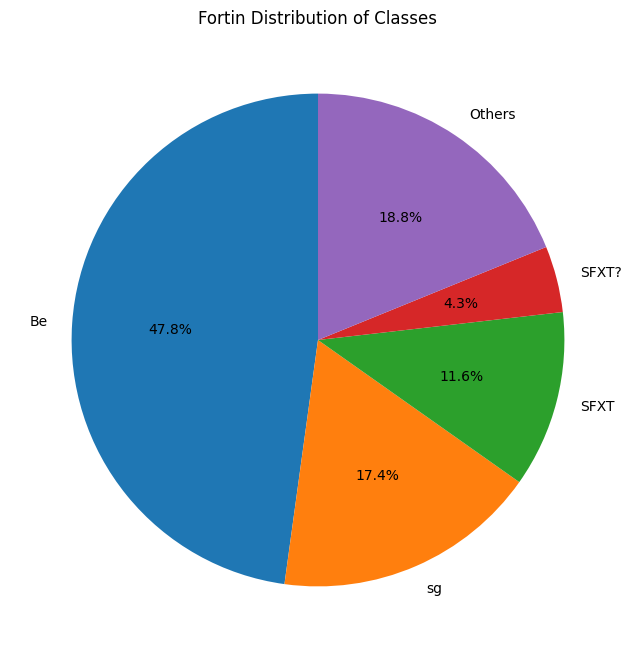

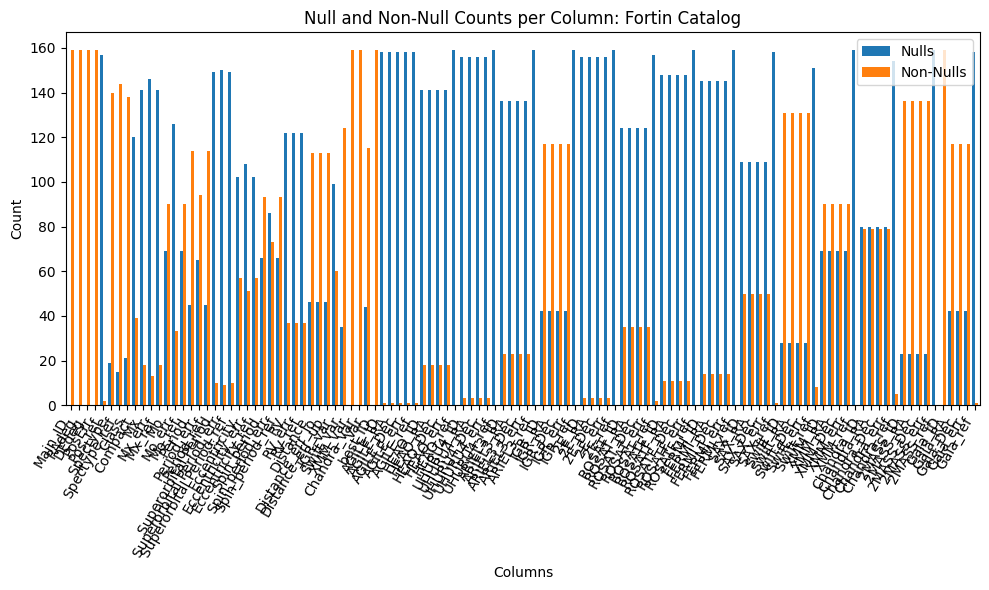

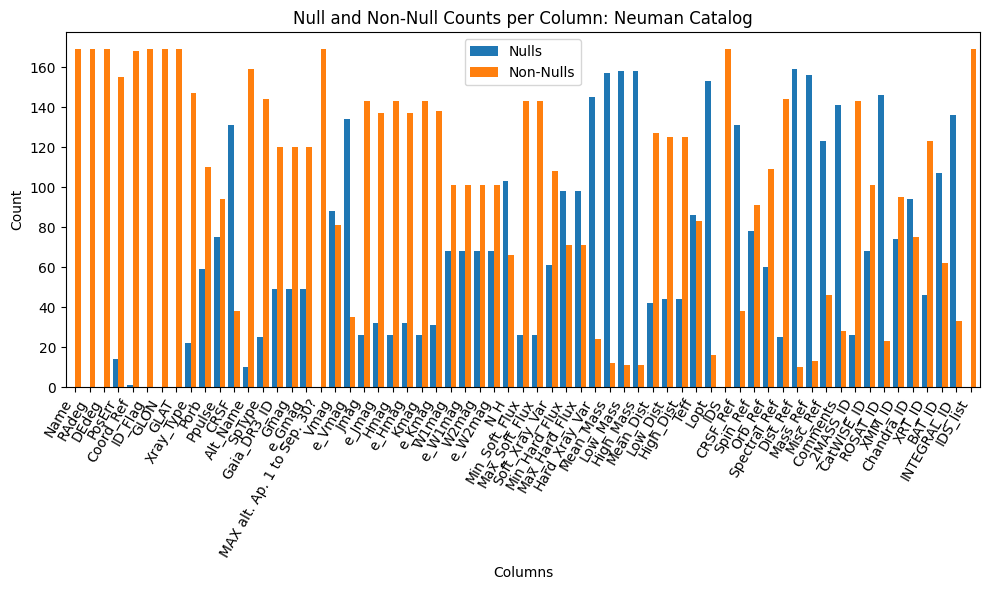

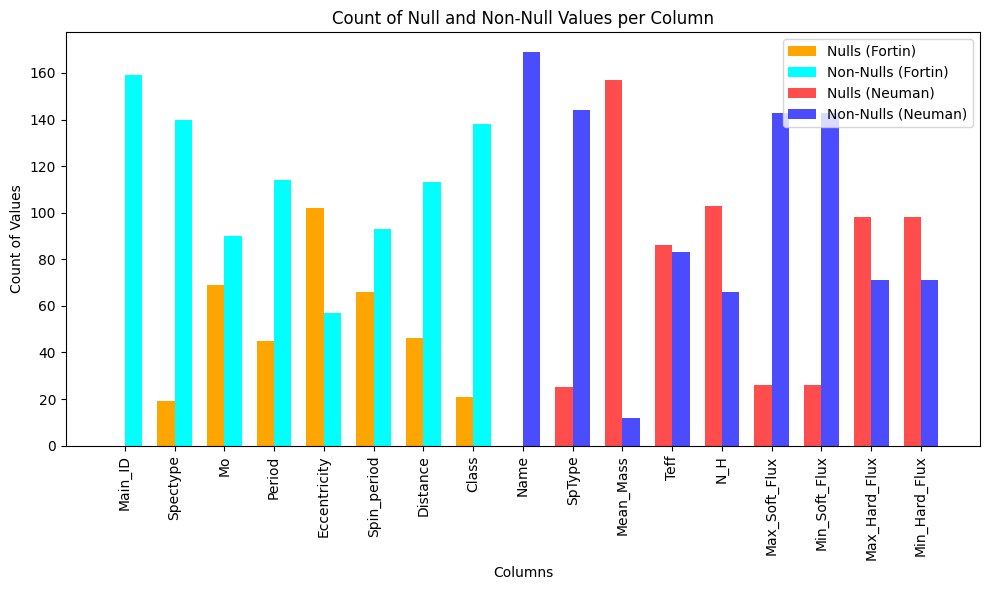

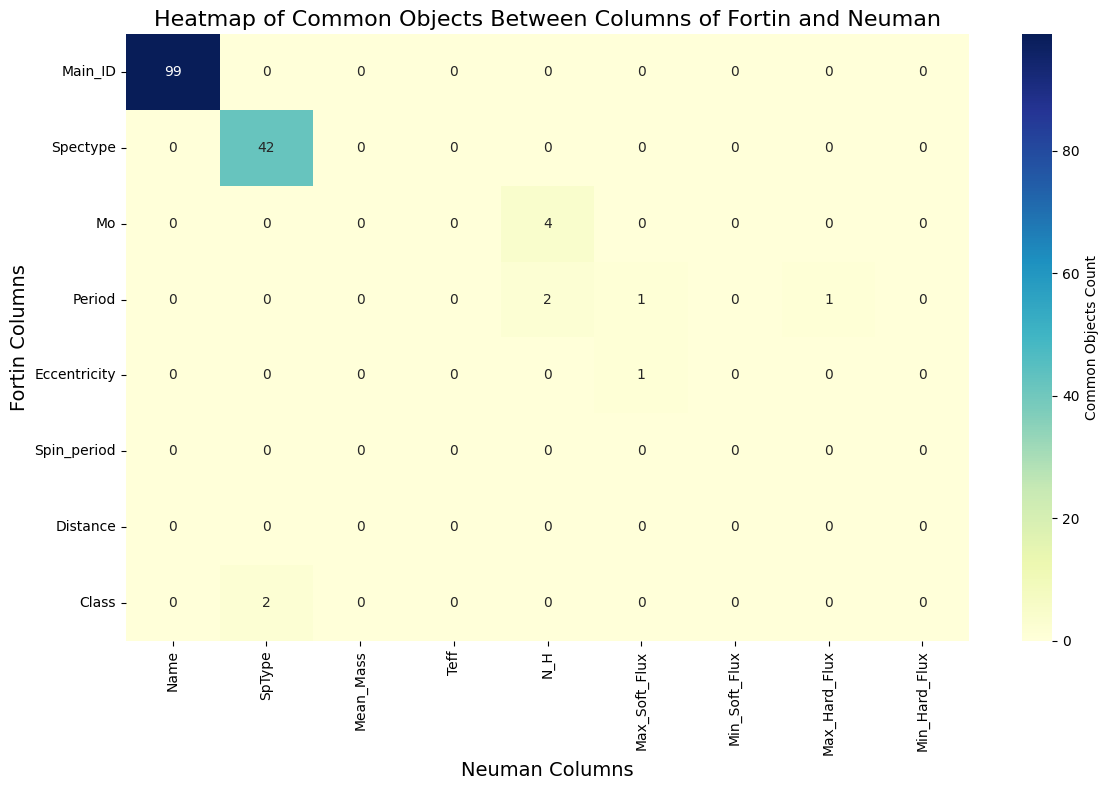

In [12]:
hmxb.Compare_Neumann_Fortin()

df_final = hmxb.Build_Final_Dataframe()

hmxb.plot_class_distribution()

hmxb.plot_null_histogram(hmxb.cat_fortin, 'Fortin Catalog')
hmxb.plot_null_histogram(hmxb.cat_neuman, 'Neuman Catalog')

columns_fortin = ['Main_ID', 'Spectype', 'Mo', 'Period', 'Eccentricity', 'Spin_period', 'Distance', 'Class']
columns_neuman = ['Name', 'SpType', 'Mean_Mass', 'Teff', 'N_H', 'Max_Soft_Flux', 'Min_Soft_Flux', 'Max_Hard_Flux', 'Min_Hard_Flux']
hmxb.compare_null_counts(columns_fortin, columns_neuman)

hmxb.plot_common_object_heatmap(columns_fortin, columns_neuman)